<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Time Series
A time series is a sequence of observations taken at regular time intervals. They can be used for tasks such as anomaly detection and classification but the most common use is forecasting. In this notebook we will use a time series from a [weather station](https://www.bgc-jena.mpg.de/wetter/) in Jena, Germany. The weather data has been collected since 1770 but we will use a smaller dataset collected between 2009 and 2016 every 10 minutes.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-06-26 16:22:56--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.141, 52.217.124.240, 54.231.228.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  63.0MB/s    in 0.2s    

2024-06-26 16:22:56 (63.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

The dataset contains 420451 records of pressure, air temperature, humidity, and other meteorological variables.

In [5]:
lines = data.split("\n")
header = lines[0].split(",")
record_0 = lines[1].split(",")
lines = lines[1:]
print(header)
print(record_0)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
['01.01.2009 00:10:00', '996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']
420451


We create two NumPy arrays, one for the temperature values and one for the rest. The temperature values will be used as the target values of the forecasting task while the other parameters will be used as features to learn the function that links the parameters to the temperature

$$T = f(pressure, humidity, wind,..)$$

The model does not use the past values of temperature for the forecasts. This will probably reduce the skill of the model.

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

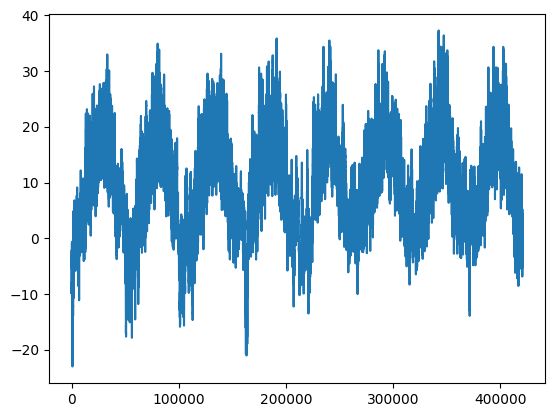

In [6]:
plt.plot(range(len(temperature)), temperature)

We plot a smaller sample of the first 10 days. Since the data is collected every 10 minutes, there are 24 * 6 * 10 = 1440 data points

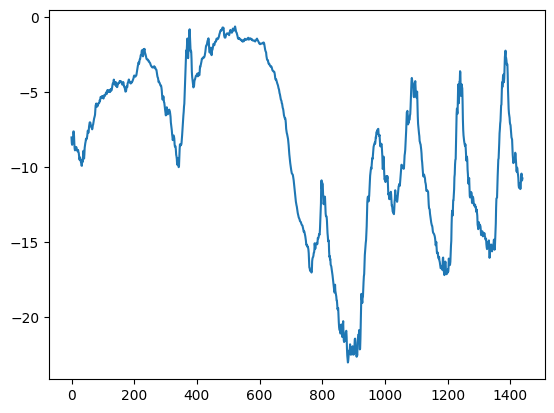

In [7]:
plt.plot(range(1440), temperature[:1440])

## The forecasting task
We want to know wheter we can make a forecast of the temperature for the next 24 hours (lead time) given the records in the previous 5 days sampled every hour. We will use the first 50% of the data for training, the following 25% for validation and the last 25% for testing.    

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Since the range of values of the variables is different we normalize the data by subtracting the mean and dividing by the standard deviation

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### Data preparation
In order to train a model for time series forecasting we have to sample our dataset, the observations. For example we want to use one observation every 6 since we assume the sequence is highly correlated. So we set the sampling rate to 6. Then we have to decide the length of the sequences for the training. For instance we may assume that 5 days of observations is enough to make a forecast for the next 24 hours. Therefore we set the length of the sequences to 5 x 24 = 120 observations. Finally we set the delay to extract the target sequence to be the same as the lead time we want our model to be able to forecast. So for each sequence extracted from the time series we can extract the target sequence just using a delay of the same length as the lead time. One last value we have to set is the number of sequences in a batch.  

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

We use a function utility from keras to create the training and validation set and the test set.

In [11]:
train_dataset = keras.utils.timeseries_dataset_from_array(
                                                        raw_data[:-delay],
                                                        targets=temperature[delay:],
                                                        sampling_rate=sampling_rate,
                                                        sequence_length=sequence_length,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        start_index=0,
                                                        end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
                                                        raw_data[:-delay],
                                                        targets=temperature[delay:],
                                                        sampling_rate=sampling_rate,
                                                        sequence_length=sequence_length,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        start_index=num_train_samples,
                                                        end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
                                                        raw_data[:-delay],
                                                        targets=temperature[delay:],
                                                        sampling_rate=sampling_rate,
                                                        sequence_length=sequence_length,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        start_index=num_train_samples + num_val_samples)

Our datasets are tuples of an input sequence of 120 data points and a target delayed temperature value. As said, the inputs are variables such as pressure, wind speed, humidity, and other meteorological variables. The sequences in each dataset are shuffled, that is their position in the dataset is random but the observations in each sequence are kept in the same order.

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## The baseline
Before building our forecasting model we may want to build a simpler common-sense model, a baseline, to compare its skill against it. We assume our baseline model to always forecast the last temperature values for the next 24 hours. We can compute the mean absolute error (MAE) as the absolute difference between such predictions and the observations.  

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1] # invertion of the normalized data
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [14]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## A simple shallow neural network model
Before building a deep neural network we build another simple model based of a shallow neural network. We flatten the input data to compute the weights in the fully connected layer but this operation destroys the time order.

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [16]:
callbacks = [
             keras.callbacks.ModelCheckpoint("jena_dense.keras",
             save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 12.7103 - mae: 2.7545 - val_loss: 13.7041 - val_mae: 2.9446
Epoch 2/10
819/819 [==============================] - 39s 48ms/step - loss: 9.0385 - mae: 2.3602 - val_loss: 11.9394 - val_mae: 2.7297
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.2622 - mae: 2.2599 - val_loss: 10.3541 - val_mae: 2.5540
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 7.8109 - mae: 2.1971 - val_loss: 10.6833 - val_mae: 2.5911
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 7.4933 - mae: 2.1541 - val_loss: 10.4993 - val_mae: 2.5648
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 7.2474 - mae: 2.1182 - val_loss: 11.0901 - val_mae: 2.6378
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 7.0740 - mae: 2.0904 - val_loss: 10.9235 - val_mae: 2.6248
Epoch 8/10
819/819 [==============================] - 

We assess the performance of the shallow neural network model on the test set. We achieve a MAE of 2.70, similar to that achieved by the common-sense baseline model.

In [17]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 12.1178 - mae: 2.7471
Test MAE: 2.75


In [18]:
def plot_mae(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

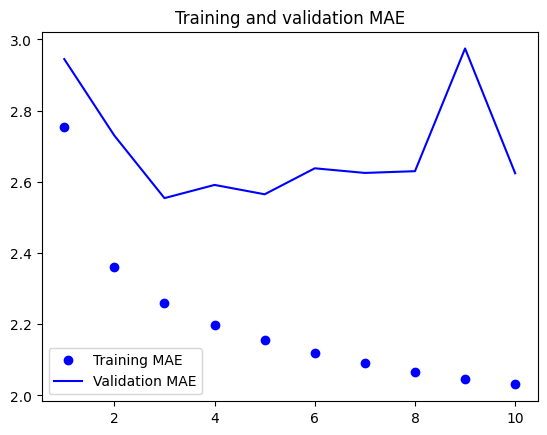

In [19]:
plot_mae(history)

## A 1D convolutional model
The shallow neural network did not achieve a better result than the common-sense baseline so we try another model slightly more comlex than the shallow model: a one dimensional convolution. It works like the 2D convolution but only in one dimension. As for a 2D filter learnt by a convolution model the output of a 1D filter should not depend on the location on the sequence and be able to extract a pattern wherever it is. We start with a kernel (window) of 24 datapoints for the first layer and then we halve the window. The last layer contains only one unit and outputs a real value for the temperature. We use MaxPooling in the model to reduce the size of the feature maps but this operation destroys the time order information.  

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x) # max pooling destroys the time information
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [22]:
callbacks = [
   keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 43s 49ms/step - loss: 23.5277 - mae: 3.8257 - val_loss: 19.6697 - val_mae: 3.4396
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 15.8471 - mae: 3.1659 - val_loss: 18.1348 - val_mae: 3.3998
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 13.7420 - mae: 2.9470 - val_loss: 14.9022 - val_mae: 3.0448
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 12.9144 - mae: 2.8493 - val_loss: 15.0646 - val_mae: 3.0716
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 12.3973 - mae: 2.7872 - val_loss: 14.3504 - val_mae: 2.9834
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 11.9869 - mae: 2.7418 - val_loss: 16.3071 - val_mae: 3.2084
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 11.6596 - mae: 2.7036 - val_loss: 14.2888 - val_mae: 2.9874
Epoch 8/10
819/819 [============================

The performance of the 1D convolution model  on the test set with a MAE of 3.11 is even worse than the shallow model.

In [23]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 32ms/step - loss: 15.4236 - mae: 3.1133
Test MAE: 3.11


## A simple LSTM-based model
We have seen two machine learning models that do not do better than the common-sense baseline model. That does not mean that a machine learning approach, and in particular those based on neural networks, cannot be used to deal with time series. The recurrent neural networks is a family of models specifically built to deal with time series.

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [26]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 48s 53ms/step - loss: 41.7977 - mae: 4.7304 - val_loss: 13.0967 - val_mae: 2.7677
Epoch 2/10
819/819 [==============================] - 41s 49ms/step - loss: 11.1522 - mae: 2.5947 - val_loss: 9.7096 - val_mae: 2.4223
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 9.6950 - mae: 2.4362 - val_loss: 9.9340 - val_mae: 2.4497
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 9.3060 - mae: 2.3848 - val_loss: 9.9893 - val_mae: 2.4600
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 8.9977 - mae: 2.3446 - val_loss: 9.9296 - val_mae: 2.4501
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 8.7495 - mae: 2.3085 - val_loss: 9.7507 - val_mae: 2.4283
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 8.5765 - mae: 2.2840 - val_loss: 9.6558 - val_mae: 2.4142
Epoch 8/10
819/819 [==============================] - 40s 4

This time the model's performance is better than the baseline. It achieves a MAE of 2.60 against the 2.62 of the baseline, a little improvement but still an improvement. The reason why a recurrent model achieves a better result than the fully connected and convolutional model is that these two models do not have memory. No information is kept about the state of the system being modeled after an input sequence has been processed. So the reasons why the fully connected and the convolutional model do not work when dealing with time series is twofold. The first reason is that they process a sequence of data points as one single array of values without paying attention to the temporal order, and the second reason is that they do not have memory.

In [27]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 35ms/step - loss: 12.3545 - mae: 2.5966
Test MAE: 2.60


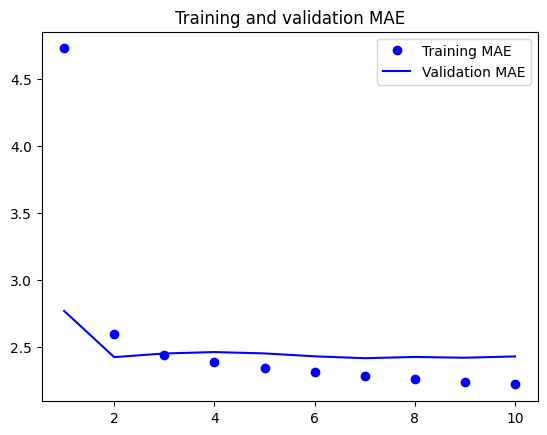

In [28]:
plot_mae(history)

## Recurrent neural networks
The LSTM model that achieved a result better than the baseline is part of the recurrent neural network family models. These models are based on a recurrent connection that keeps the information about the state of the network simply by adding the output of the previous input to the input to produce the next output.

![recurrent connection](https://github.com/luigiselmi/dl_tensorflow/blob/main/images/recurrent_connection.jpg?raw=1)

Each sequence in a batch is processed recursively and not as one single data point. There are several ways to implement such recurrence and that is the reason why there exist many recurrent networks. An LSTM recurrent network can manage long sequences avoiding the *vanishing gradient* problem during training.

### Recurrent dropout to fight overfitting
If we look at the loss and validation plot of our LSTM model we can see that the validation and the training loss diverge just after few epoch. This is a sign of overfitting. Keras implements a dropout layer that is specific for recurrent networks but the idea is the same as for the fully connected layers: reducing the number of parameters. In order to train the next model it is recommended to switch to a GPU runtime.

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [1]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

NameError: name 'model' is not defined